In [1]:
import DataLoading
from torch.utils.data import DataLoader,TensorDataset
import torch
import pandas as pd
import NN_classes
import training_methods
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
sc = "sc01"
period = "2030"
folder = "../Data/RTS24_AC_12w"
all_executions = DataLoading.list_executions(folder="../Data/RTS24_AC_12w",per = period,sc=sc)
executions = all_executions[1:20]
te_s = 0.3
val_s = 0.4

In [3]:
dfs_in,dfs_out = DataLoading.load_data(folder,executions,period,sc)

input_f_sc01_Network_Line_In_N_101_N_102_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_101_N_103_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_101_N_105_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_102_N_104_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_102_N_106_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_103_N_109_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_103_N_124_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_104_N_109_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_105_N_110_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_106_N_108_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_106_N_110_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_107_N_108_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_108_N_109_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_108_N_110_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_109_N_111_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_109_N_112_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_110_N_111

In [4]:
ts_in,ts_out =  DataLoading.split_tr_val_te_by_exec(dfs_in,dfs_out,executions,te_s,val_s,False)

In [5]:
d_ft_in, d_ft_out,maxs = DataLoading.concat_and_normalize_split_by_exec(ts_in,ts_out,executions)

In [6]:
executions = list(dfs_in.keys())
tr_exs = list(ts_in["train"].keys())
te_exs = list(ts_in["test"].keys())
val_exs = list(ts_in["val"].keys())

In [6]:
# train = TensorDataset(d_ft_in['train'].float(), d_ft_out['train'].float())
# validation = TensorDataset(d_ft_in['val'].float(), d_ft_out['val'].float())

# training_loader = DataLoader(train,batch_size=64)
# validation_loader = DataLoader(train,batch_size=64)

In [7]:
folder = "RTS24_AC_12w_split_by_exec"
mt = "min_val"


dor = 0
lr = 0.04
nb_e = 12
nb_hidden = 3

models = dict()
for dor in [0,0.1]: 
    m_name = f"OE_{nb_hidden}h_{nb_e}e_{lr}lr_{dor}dor"
    path = f"trained_models/{folder}/{mt}/model_{m_name}.pth"

    models[dor] = NN_classes.create_model(nb_hidden,d_ft_in['train'].shape[1],dropout_ratio= dor)
    models[dor].load_state_dict(torch.load(path))
    models[dor].eval()



ObjectiveEstimator_ANN_3hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=306, bias=True)
  (hidden_layer2): Linear(in_features=306, out_features=76, bias=True)
  (hidden_layer3): Linear(in_features=76, out_features=19, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (output_layer): Linear(in_features=19, out_features=1, bias=True)
) 0 3
ObjectiveEstimator_ANN_3hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=306, bias=True)
  (hidden_layer2): Linear(in_features=306, out_features=76, bias=True)
  (hidden_layer3): Linear(in_features=76, out_features=19, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (output_layer): Linear(in_features=19, out_features=1, bias=True)
) 0.1 3


In [8]:
#Check an execution part of training set

#First, select an execution
execution = tr_exs[0]
#Load the input and output data for this execution
ex_in = torch.nan_to_num(ts_in["train"][execution]/maxs)
ex_out = ts_out["train"][execution]
loss_fn_1 = torch.nn.L1Loss()
loss_fn_2 = torch.nn.MSELoss()

#Make model predictions based on input
predictions = dict()

for k in models:
    m = models[k]
    predictions[k] = m(ex_in.float())



C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([2184])) that is different to the input size (torch.Size([2184, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2184])) that is different to the input size (torch.Size([2184, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


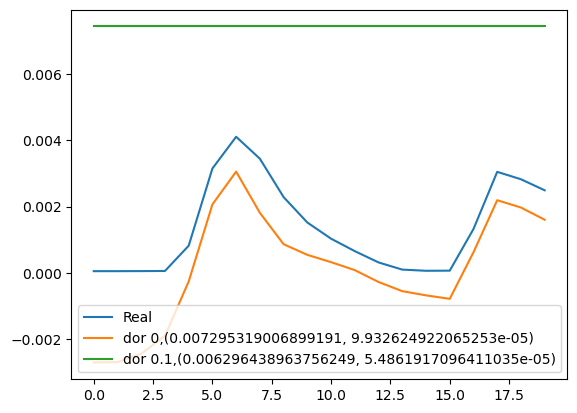

In [9]:
s = 0
e = s+20

plt.plot(ex_out[s:e],label = "Real")
for k in predictions:
    train_losses = (loss_fn_1(predictions[k],ex_out).item(),loss_fn_2(predictions[k],ex_out).item())
    plt.plot(predictions[k].detach()[s:e],label = f"dor {k},{train_losses}")
plt.legend()

MSE losses:
dor 0: 4.41159252973881e-06 4.411592528553311e-06 4.411592528553311e-06


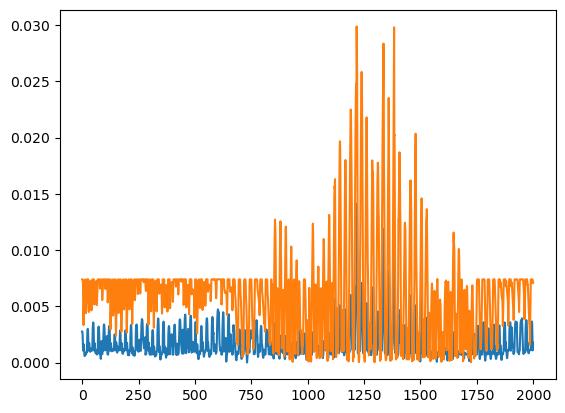

In [21]:
mae_losses = dict()
mse_losses = dict()
mse_losses_torch = dict()
s = 0
e= 2000

for dor in predictions:
    mae_losses[dor] = [abs((predictions[dor][i]-ex_out[i]).item()) for i in range(s,e) ]
    mse_losses[dor] = [((predictions[dor][i]-ex_out[i]).item())**2 for i in range(s,e) ]
    mse_losses_torch[dor] = [loss_fn_2(predictions[dor][i],ex_out[i]).item() for i in range(s,e) ]
    plt.plot(mae_losses[dor],label = dor)
#loss_fn_1(predictions[k][1],ex_out[1])

# plt.legend()
# print("MAE losses:")
# print("dor 0:",np.mean(mae_losses[0]),loss_fn_1(predictions[0][0:end],ex_out[0:end]).item())
# print("dor 0.1:",np.mean(mae_losses[.1]),loss_fn_1(predictions[0.1][0:end],ex_out[0:end]).item())

print("MSE losses:")
#print("dor 0.1:",np.mean(mse_losses[.1]),loss_fn_2(predictions[0][s:e],ex_out[s:e]).item())
print("dor 0:",np.mean(mse_losses[0]),np.mean(mse_losses_torch[0]),loss_fn_2(predictions[0][s:e].squeeze(),ex_out[s:e]).item())


In [18]:
loss_fn_2(predictions[0][s:e].squeeze(),ex_out[s:e])
#loss_fn_2(predictions[0][s:e],ex_out[s:e])

tensor(1.9995e-06, dtype=torch.float64, grad_fn=<MseLossBackward0>)

In [14]:
predictions[0].squeeze()

tensor([-0.0027, -0.0027, -0.0024,  ...,  0.0002, -0.0014, -0.0021],
       grad_fn=<SqueezeBackward0>)

In [234]:
np.mean(mse_losses_torch[0])

1.9994912316985495e-06